# Telco Customer Churn Prediction - Model Training & Evaluation

## Overview

This notebook implements an end-to-end machine learning pipeline for customer churn prediction using AWS SageMaker. We train and compare 5 different algorithms, perform hyperparameter optimization, and evaluate trained models.

### Models Evaluated
| Model | Type | Framework |
|-------|------|----------|
| XGBoost | Gradient Boosting | SageMaker Built-in |
| Linear Learner | Logistic Regression | SageMaker Built-in |
| K-Nearest Neighbors | Instance-based | SageMaker Built-in |
| Random Forest | Ensemble | Scikit-learn (Script Mode) |
| Support Vector Machine | Kernel-based | Scikit-learn (Script Mode) |

### Pipeline Steps
1. **Environment Setup** - Configure SageMaker session and S3
2. **Data Loading** - Load preprocessed data from S3
3. **Model Training** - Train all 5 models with hyperparameter tuning
4. **Model Evaluation** - Evaluate and compare performance metrics

---

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.tuner import (
    IntegerParameter,
    ContinuousParameter,
    CategoricalParameter,
    HyperparameterTuner
)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 11

print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"SageMaker SDK: {sagemaker.__version__}")
print("Libraries imported successfully")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Timestamp: 2026-02-16 09:10:26
SageMaker SDK: 2.245.0
Libraries imported successfully


In [2]:
session = sagemaker.Session()
print("SageMaker session initialized")
region = session.boto_region_name
role = get_execution_role()
s3_client = boto3.client('s3')

# ============================================
# CONFIGURATION - Update these values
# ============================================
BUCKET_NAME = 'zvonimir-telco-customer-churn'
INSTANCE_TYPE = 'ml.m5.xlarge'

S3_DATA_PATH = f's3://{BUCKET_NAME}'
S3_OUTPUT_PATH = f's3://{BUCKET_NAME}/models'

SageMaker session initialized


---

## 2. Data Loading

In [3]:
s3_client.download_file(BUCKET_NAME, 'train_smote.csv', '/tmp/train_raw.csv')
s3_client.download_file(BUCKET_NAME, 'test.csv', '/tmp/test_raw.csv')

train_df = pd.read_csv('/tmp/train_raw.csv')
test_df = pd.read_csv('/tmp/test_raw.csv')

for col in train_df.columns:
    if train_df[col].dtype == 'bool' or train_df[col].dtype == 'object':
        train_df[col] = train_df[col].map({True: 1, False: 0, 'True': 1, 'False': 0}).fillna(train_df[col])
        test_df[col] = test_df[col].map({True: 1, False: 0, 'True': 1, 'False': 0}).fillna(test_df[col])

train_df = train_df.apply(pd.to_numeric, errors='coerce').fillna(0)
test_df = test_df.apply(pd.to_numeric, errors='coerce').fillna(0)

X_train = train_df.drop('Churn', axis=1)
y_train = train_df['Churn'].astype(int)
X_test = test_df.drop('Churn', axis=1)
y_test = test_df['Churn'].astype(int)

print(f'Training samples: {len(train_df):,}')
print(f'Test samples: {len(test_df):,}')
print(f'Features: {X_train.shape[1]}')
print('Data loaded and converted to numeric')

Training samples: 8,278
Test samples: 1,409
Features: 46
Data loaded and converted to numeric


### Prepare Data for AWS Sagemaker

In [4]:
train_sagemaker = pd.concat([y_train, X_train], axis=1)
test_sagemaker = pd.concat([y_test, X_test], axis=1)

train_sagemaker.to_csv('/tmp/train_sm.csv', index=False, header=False)
test_sagemaker.to_csv('/tmp/test_sm.csv', index=False, header=False)

train_df.to_csv('/tmp/train_sklearn.csv', index=False)
test_df.to_csv('/tmp/test_sklearn.csv', index=False)

train_sm_s3 = session.upload_data('/tmp/train_sm.csv', bucket=BUCKET_NAME, key_prefix='data/train')
test_sm_s3 = session.upload_data('/tmp/test_sm.csv', bucket=BUCKET_NAME, key_prefix='data/test')
train_sklearn_s3 = session.upload_data('/tmp/train_sklearn.csv', bucket=BUCKET_NAME, key_prefix='data/sklearn/train')
test_sklearn_s3 = session.upload_data('/tmp/test_sklearn.csv', bucket=BUCKET_NAME, key_prefix='data/sklearn/test')

train_input = TrainingInput(s3_data=train_sm_s3, content_type='text/csv')
test_input = TrainingInput(s3_data=test_sm_s3, content_type='text/csv')

print('SageMaker Built-in (no headers, target first):')
print(f'  Train: {train_sm_s3}')
print(f'  Test: {test_sm_s3}')
print('Scikit-learn (with headers):')
print(f'  Train: {train_sklearn_s3}')
print(f'  Test: {test_sklearn_s3}')
print('Data uploaded to S3')

SageMaker Built-in (no headers, target first):
  Train: s3://zvonimir-telco-customer-churn/data/train/train_sm.csv
  Test: s3://zvonimir-telco-customer-churn/data/test/test_sm.csv
Scikit-learn (with headers):
  Train: s3://zvonimir-telco-customer-churn/data/sklearn/train/train_sklearn.csv
  Test: s3://zvonimir-telco-customer-churn/data/sklearn/test/test_sklearn.csv
Data uploaded to S3


In [5]:
model_results = {}

def log_model_result(name, objective_value, job_name, estimator, hyperparams=None):
    """Store model training results."""
    model_results[name] = {
        'ObjectiveValue': objective_value,
        'Job': job_name,
        'Estimator': estimator,
        'Hyperparameters': hyperparams or {},
        'Timestamp': datetime.now().isoformat()
    }
    print(f"{name} | HPO Objective Value: {objective_value:.4f}")

print("Results tracker initialized")

Results tracker initialized


---

## 3. Model Training

### 3.1 XGBoost (SageMaker Built-in)

Gradient boosting algorithm optimized for structured/tabular data. Uses Bayesian optimization for hyperparameter tuning.

In [6]:
xgb_image = sagemaker.image_uris.retrieve('xgboost', region, version='latest')

xgb_estimator = sagemaker.estimator.Estimator(
    image_uri=xgb_image,
    role=role,
    instance_count=1,
    instance_type=INSTANCE_TYPE,
    output_path=f'{S3_OUTPUT_PATH}/xgboost',
    sagemaker_session=session
)

xgb_estimator.set_hyperparameters(
    objective='binary:logistic',
    num_round=100,
    eval_metric='auc'
)

xgb_hp_ranges = {
    'max_depth': IntegerParameter(3, 10),
    'eta': ContinuousParameter(0.01, 0.3),
    'subsample': ContinuousParameter(0.5, 1.0),
    'colsample_bytree': ContinuousParameter(0.5, 1.0),
    'min_child_weight': IntegerParameter(1, 10),
    'alpha': ContinuousParameter(0, 2)
}

print("XGBoost Hyperparameter Ranges:")
for k, v in xgb_hp_ranges.items():
    print(f"  {k}: {v.__dict__}")

XGBoost Hyperparameter Ranges:
  max_depth: {'min_value': 3, 'max_value': 10, 'scaling_type': 'Auto'}
  eta: {'min_value': 0.01, 'max_value': 0.3, 'scaling_type': 'Auto'}
  subsample: {'min_value': 0.5, 'max_value': 1.0, 'scaling_type': 'Auto'}
  colsample_bytree: {'min_value': 0.5, 'max_value': 1.0, 'scaling_type': 'Auto'}
  min_child_weight: {'min_value': 1, 'max_value': 10, 'scaling_type': 'Auto'}
  alpha: {'min_value': 0, 'max_value': 2, 'scaling_type': 'Auto'}


In [7]:
xgb_tuner = HyperparameterTuner(
    estimator=xgb_estimator,
    objective_metric_name='validation:auc',
    hyperparameter_ranges=xgb_hp_ranges,
    max_jobs=15,
    max_parallel_jobs=3,
    objective_type='Maximize',
    strategy='Bayesian'
)

print("Starting XGBoost hyperparameter tuning (15 jobs)...")
xgb_tuner.fit({'train': train_input, 'validation': test_input}, wait=True)

xgb_analytics = sagemaker.HyperparameterTuningJobAnalytics(xgb_tuner.latest_tuning_job.job_name)
xgb_df = xgb_analytics.dataframe().sort_values('FinalObjectiveValue', ascending=False)
xgb_best_auc = xgb_df.iloc[0]['FinalObjectiveValue']

log_model_result('XGBoost', xgb_best_auc, xgb_tuner.best_training_job(), xgb_tuner.best_estimator())

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Starting XGBoost hyperparameter tuning (15 jobs)...
.....................................................................!

2026-02-16 09:14:54 Starting - Found matching resource for reuse
2026-02-16 09:14:54 Downloading - Downloading the training image
2026-02-16 09:14:54 Training - Training image download completed. Training in progress.
2026-02-16 09:14:54 Uploading - Uploading generated training model
2026-02-16 09:14:54 Completed - Resource reused by training job: xgboost-260216-0910-011-9f99f443
XGBoost | HPO Objective Value: 0.8402


### 3.2 Linear Learner (SageMaker Built-in)

Binary classifier using logistic regression with L1/L2 regularization.

In [8]:
ll_image = sagemaker.image_uris.retrieve('linear-learner', region)

ll_estimator = sagemaker.estimator.Estimator(
    image_uri=ll_image,
    role=role,
    instance_count=1,
    instance_type=INSTANCE_TYPE,
    output_path=f'{S3_OUTPUT_PATH}/linear-learner',
    sagemaker_session=session
)

ll_estimator.set_hyperparameters(
    predictor_type='binary_classifier',
    feature_dim=X_train.shape[1],
    epochs=15,
    normalize_data=True
)

ll_hp_ranges = {
    'learning_rate': ContinuousParameter(0.0001, 0.1),
    'l1': ContinuousParameter(0, 1),
    'wd': ContinuousParameter(0, 1),
    'mini_batch_size': IntegerParameter(100, 500)
}

print("Linear Learner Hyperparameter Ranges:")
for k, v in ll_hp_ranges.items():
    print(f"  {k}: {v.__dict__}")

Linear Learner Hyperparameter Ranges:
  learning_rate: {'min_value': 0.0001, 'max_value': 0.1, 'scaling_type': 'Auto'}
  l1: {'min_value': 0, 'max_value': 1, 'scaling_type': 'Auto'}
  wd: {'min_value': 0, 'max_value': 1, 'scaling_type': 'Auto'}
  mini_batch_size: {'min_value': 100, 'max_value': 500, 'scaling_type': 'Auto'}


In [9]:
ll_tuner = HyperparameterTuner(
    estimator=ll_estimator,
    objective_metric_name='validation:binary_f_beta',
    hyperparameter_ranges=ll_hp_ranges,
    max_jobs=15,
    max_parallel_jobs=3,
    objective_type='Maximize'
)

print("Starting Linear Learner hyperparameter tuning (15 jobs)...")
ll_tuner.fit({'train': train_input, 'validation': test_input}, wait=True)

ll_analytics = sagemaker.HyperparameterTuningJobAnalytics(ll_tuner.latest_tuning_job.job_name)
ll_df = ll_analytics.dataframe().sort_values('FinalObjectiveValue', ascending=False)
ll_best_score = ll_df.iloc[0]['FinalObjectiveValue']

log_model_result('Linear Learner', ll_best_score, ll_tuner.best_training_job(), ll_tuner.best_estimator())

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Starting Linear Learner hyperparameter tuning (15 jobs)...
..................................................................................!

2026-02-16 09:30:59 Starting - Preparing the instances for training
2026-02-16 09:30:59 Downloading - Downloading the training image
2026-02-16 09:30:59 Training - Training image download completed. Training in progress.
2026-02-16 09:30:59 Uploading - Uploading generated training model
2026-02-16 09:30:59 Completed - Resource reused by training job: linear-learner-260216-0927-006-8e78fc2e
Linear Learner | HPO Objective Value: 0.5897


### 3.3 K-Nearest Neighbors (SageMaker Built-in)

Instance-based learning algorithm for classification.

In [10]:
knn_image = sagemaker.image_uris.retrieve('knn', region)

knn_estimator = sagemaker.estimator.Estimator(
    image_uri=knn_image,
    role=role,
    instance_count=1,
    instance_type=INSTANCE_TYPE,
    output_path=f'{S3_OUTPUT_PATH}/knn',
    sagemaker_session=session
)

knn_estimator.set_hyperparameters(
    predictor_type='classifier',
    feature_dim=X_train.shape[1],
    sample_size=len(train_df)
)

knn_hp_ranges = {
    'k': IntegerParameter(5, 100),
}

print("KNN Hyperparameter Ranges:")
for k, v in knn_hp_ranges.items():
    print(f"  {k}: {v.__dict__}")

KNN Hyperparameter Ranges:
  k: {'min_value': 5, 'max_value': 100, 'scaling_type': 'Auto'}


In [11]:
knn_tuner = HyperparameterTuner(
    estimator=knn_estimator,
    objective_metric_name='test:accuracy',
    hyperparameter_ranges=knn_hp_ranges,
    max_jobs=15,
    max_parallel_jobs=2,
    objective_type='Maximize'
)

print("Starting KNN hyperparameter tuning (15 jobs)...")
knn_tuner.fit({'train': train_input, 'test': test_input}, wait=True)

knn_analytics = sagemaker.HyperparameterTuningJobAnalytics(knn_tuner.latest_tuning_job.job_name)
knn_df = knn_analytics.dataframe().sort_values('FinalObjectiveValue', ascending=False)
knn_best_score = knn_df.iloc[0]['FinalObjectiveValue']

log_model_result('KNN', knn_best_score, knn_tuner.best_training_job(), knn_tuner.best_estimator())

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Starting KNN hyperparameter tuning (15 jobs)...
..............................................................................................................!

2026-02-16 09:40:55 Starting - Found matching resource for reuse
2026-02-16 09:40:55 Downloading - Downloading the training image
2026-02-16 09:40:55 Training - Training image download completed. Training in progress.
2026-02-16 09:40:55 Uploading - Uploading generated training model
2026-02-16 09:40:55 Completed - Resource reused by training job: knn-260216-0935-008-37eee44d
KNN | HPO Objective Value: 0.7452


### 3.4 Random Forest (Scikit-learn Script Mode)

Ensemble learning method using multiple decision trees.

In [12]:
print('Training scripts available in scripts/ directory')
print('rf_train.py - Random Forest')
print('svm_train.py - Support Vector Machine')

Training scripts available in scripts/ directory
rf_train.py - Random Forest
svm_train.py - Support Vector Machine


In [13]:
rf_estimator = SKLearn(
    entry_point='rf_train.py',
    source_dir='scripts',
    role=role,
    instance_count=1,
    instance_type=INSTANCE_TYPE,
    framework_version='1.2-1',
    py_version='py3',
    output_path=f'{S3_OUTPUT_PATH}/random-forest',
    sagemaker_session=session,
    hyperparameters={'n-estimators': 100, 'max-depth': 10}
)

rf_hp_ranges = {
    'n-estimators': IntegerParameter(50, 300),
    'max-depth': IntegerParameter(5, 30),
    'min-samples-split': IntegerParameter(2, 20),
    'min-samples-leaf': IntegerParameter(1, 10)
}

print('Random Forest Hyperparameter Ranges:')
for k, v in rf_hp_ranges.items():
    print(f'  {k}: {v.__dict__}')

Random Forest Hyperparameter Ranges:
  n-estimators: {'min_value': 50, 'max_value': 300, 'scaling_type': 'Auto'}
  max-depth: {'min_value': 5, 'max_value': 30, 'scaling_type': 'Auto'}
  min-samples-split: {'min_value': 2, 'max_value': 20, 'scaling_type': 'Auto'}
  min-samples-leaf: {'min_value': 1, 'max_value': 10, 'scaling_type': 'Auto'}


In [14]:
rf_tuner = HyperparameterTuner(
    estimator=rf_estimator,
    objective_metric_name='Test-AUC',
    hyperparameter_ranges=rf_hp_ranges,
    metric_definitions=[
        {'Name': 'Test-AUC', 'Regex': 'Test-AUC: ([0-9\\.]+)'},
        {'Name': 'Train-AUC', 'Regex': 'Train-AUC: ([0-9\\.]+)'}
    ],
    max_jobs=15,
    max_parallel_jobs=3,
    objective_type='Maximize'
)

print("Starting Random Forest hyperparameter tuning (15 jobs)...")
rf_tuner.fit({'train': train_sklearn_s3, 'test': test_sklearn_s3}, wait=True)

rf_analytics = sagemaker.HyperparameterTuningJobAnalytics(rf_tuner.latest_tuning_job.job_name)
rf_df = rf_analytics.dataframe().sort_values('FinalObjectiveValue', ascending=False)
rf_best_auc = rf_df.iloc[0]['FinalObjectiveValue']

log_model_result('Random Forest', rf_best_auc, rf_tuner.best_training_job(), rf_tuner.best_estimator())

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Starting Random Forest hyperparameter tuning (15 jobs)...
....................................................................!

2026-02-16 09:55:16 Starting - Found matching resource for reuse
2026-02-16 09:55:16 Downloading - Downloading the training image
2026-02-16 09:55:16 Training - Training image download completed. Training in progress.
2026-02-16 09:55:16 Uploading - Uploading generated training model
2026-02-16 09:55:16 Completed - Resource retained for reuse
Random Forest | HPO Objective Value: 0.8383


### 3.5 Support Vector Machine (Scikit-learn Script Mode)

Kernel-based classifier using hyperplane separation.

In [15]:
svm_estimator = SKLearn(
    entry_point='svm_train.py',
    source_dir='scripts',
    role=role,
    instance_count=1,
    instance_type=INSTANCE_TYPE,
    framework_version='1.2-1',
    py_version='py3',
    output_path=f'{S3_OUTPUT_PATH}/svm',
    sagemaker_session=session,
    hyperparameters={'C': 1.0, 'kernel': 'rbf'}
)

svm_hp_ranges = {
    'C': ContinuousParameter(0.1, 10),
    'kernel': CategoricalParameter(['rbf', 'linear', 'poly'])
}

print('SVM Hyperparameter Ranges:')
for k, v in svm_hp_ranges.items():
    print(f'  {k}: {v}')

SVM Hyperparameter Ranges:
  C: <sagemaker.parameter.ContinuousParameter object at 0x7f8917560fe0>
  kernel: <sagemaker.parameter.CategoricalParameter object at 0x7f8917560f50>


In [16]:
svm_tuner = HyperparameterTuner(
    estimator=svm_estimator,
    objective_metric_name='Test-AUC',
    hyperparameter_ranges=svm_hp_ranges,
    metric_definitions=[
        {'Name': 'Test-AUC', 'Regex': 'Test-AUC: ([0-9\\.]+)'},
        {'Name': 'Train-AUC', 'Regex': 'Train-AUC: ([0-9\\.]+)'}
    ],
    max_jobs=15,
    max_parallel_jobs=2,
    objective_type='Maximize'
)

print("Starting SVM hyperparameter tuning (15 jobs)...")
svm_tuner.fit({'train': train_sklearn_s3, 'test': test_sklearn_s3}, wait=True)

svm_analytics = sagemaker.HyperparameterTuningJobAnalytics(svm_tuner.latest_tuning_job.job_name)
svm_df = svm_analytics.dataframe().sort_values('FinalObjectiveValue', ascending=False)
svm_best_auc = svm_df.iloc[0]['FinalObjectiveValue']

log_model_result('SVM', svm_best_auc, svm_tuner.best_training_job(), svm_tuner.best_estimator())

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Starting SVM hyperparameter tuning (15 jobs)...
.........................................................................................................................!

2026-02-16 10:03:08 Starting - Preparing the instances for training
2026-02-16 10:03:08 Downloading - Downloading the training image
2026-02-16 10:03:08 Training - Training image download completed. Training in progress.
2026-02-16 10:03:08 Uploading - Uploading generated training model
2026-02-16 10:03:08 Completed - Resource reused by training job: sagemaker-scikit-lea-260216-1000-004-c1fc4790
SVM | HPO Objective Value: 0.8311


---

## 4. Comprehensive Model Evaluation

### Evaluation Pipeline
1. **Deploy Models** — Temporarily deploy each best model for prediction
2. **Classification Metrics** — Accuracy, Precision, Recall, F1, AUC-ROC, MCC, Specificity
3. **Confusion Matrices** — Visualize TP, TN, FP, FN for each model
4. **ROC Curves** — Compare discriminative ability across models
5. **Overfitting Analysis** — Training vs. validation performance gap

In [17]:
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve,
    precision_score, recall_score, f1_score, accuracy_score,
    roc_auc_score, matthews_corrcoef
)
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer, StringDeserializer


def deploy_and_predict(name, estimator, X_data):
    """Deploy best estimator, collect predictions on test set, then clean up endpoint."""

    # XGBoost returns comma-separated text; all others return JSON
    if name == 'XGBoost':
        deser = StringDeserializer()
    else:
        deser = JSONDeserializer()

    predictor = estimator.deploy(
        initial_instance_count=1,
        instance_type='ml.t2.medium',
        serializer=CSVSerializer(),
        deserializer=deser
    )

    try:
        y_pred, y_prob = [], []
        batch_size = 500

        for i in range(0, len(X_data), batch_size):
            batch = X_data.iloc[i:i + batch_size].values
            result = predictor.predict(batch)

            if name == 'XGBoost':
                probs = [float(x) for x in result.strip().split(',')]
                y_prob.extend(probs)
                y_pred.extend([1 if p >= 0.5 else 0 for p in probs])

            elif name == 'Linear Learner':
                for p in result['predictions']:
                    y_pred.append(int(float(p['predicted_label'])))
                    y_prob.append(float(p['score']))

            elif name == 'KNN':
                for p in result['predictions']:
                    y_pred.append(int(float(p['predicted_label'])))
                # KNN does not natively return calibrated probabilities

            else:  # Scikit-learn models (Random Forest, SVM)
                probs = result
                y_prob.extend(probs)
                y_pred.extend([1 if p >= 0.5 else 0 for p in probs])

        return np.array(y_pred), np.array(y_prob) if y_prob else None

    finally:
        try:
            predictor.delete_endpoint()
        except Exception:
            pass
        try:
            predictor.delete_model()
        except Exception:
            pass


def compute_all_metrics(y_true, y_pred, y_prob=None):
    """Return a dict of classification metrics and the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    metrics = {
        'Accuracy':    accuracy_score(y_true, y_pred),
        'Precision':   precision_score(y_true, y_pred, zero_division=0),
        'Recall':      recall_score(y_true, y_pred, zero_division=0),
        'F1-Score':    f1_score(y_true, y_pred, zero_division=0),
        'Specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
        'MCC':         matthews_corrcoef(y_true, y_pred),
        'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn,
    }
    if y_prob is not None:
        metrics['AUC-ROC'] = roc_auc_score(y_true, y_prob)

    return metrics, cm


print("Evaluation helpers loaded")

Evaluation helpers loaded


In [18]:
# ============================================================
# DEPLOY MODELS & COLLECT PREDICTIONS ON TEST SET
# ============================================================
# Each best model is temporarily deployed from its estimator,
# used for prediction, then the endpoint is deleted.
# This may take ~10-15 minutes for all 5 models.
# ============================================================

print("Deploying each model's best estimator for evaluation...\n")

predictions = {}

for name in model_results:
    estimator = model_results[name]['Estimator']
    print(f"[{name}]  Deploying...", end=" ", flush=True)
    try:
        y_pred, y_prob = deploy_and_predict(name, estimator, X_test)
        predictions[name] = {'y_pred': y_pred, 'y_prob': y_prob}
        print(f"Done ({len(y_pred)} predictions)")
    except Exception as e:
        print(f"FAILED — {e}")

print(f"\nEvaluated {len(predictions)} / {len(model_results)} models successfully")

Deploying each model's best estimator for evaluation...

[XGBoost]  Deploying... -----------!Done (1409 predictions)
[Linear Learner]  Deploying... ----------------!Done (1409 predictions)
[KNN]  Deploying... -----------------!Done (1409 predictions)
[Random Forest]  Deploying... -----------!Done (1409 predictions)
[SVM]  Deploying... --------------!Done (1409 predictions)

Evaluated 5 / 5 models successfully


In [19]:
# ============================================================
# COMPUTE COMPREHENSIVE METRICS FOR EACH MODEL
# ============================================================

eval_metrics = {}

for name, pred_data in predictions.items():
    metrics, cm = compute_all_metrics(
        y_test, pred_data['y_pred'], pred_data['y_prob']
    )
    eval_metrics[name] = metrics
    eval_metrics[name]['confusion_matrix'] = cm

# Build comparison DataFrame
METRIC_COLS = ['Accuracy', 'Precision', 'Recall', 'F1-Score',
               'Specificity', 'MCC', 'AUC-ROC']

rows = []
for name, m in eval_metrics.items():
    row = {'Model': name}
    for col in METRIC_COLS:
        row[col] = m.get(col, np.nan)
    rows.append(row)

metrics_df = (pd.DataFrame(rows)
              .sort_values('F1-Score', ascending=False)
              .reset_index(drop=True))

print("\n" + "=" * 100)
print("COMPREHENSIVE MODEL EVALUATION")
print("=" * 100)
print(metrics_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))
print("=" * 100)

# Classification report per model
for name in eval_metrics:
    pred_data = predictions[name]
    print(f"\n--- {name} ---")
    print(classification_report(y_test, pred_data['y_pred'],
                                target_names=['No Churn', 'Churn']))


COMPREHENSIVE MODEL EVALUATION
         Model  Accuracy  Precision  Recall  F1-Score  Specificity    MCC  AUC-ROC
       XGBoost    0.7686     0.5480  0.7326    0.6270       0.7816 0.4746   0.8402
 Random Forest    0.7700     0.5510  0.7219    0.6250       0.7874 0.4723   0.8383
           SVM    0.7516     0.5227  0.7380    0.6120       0.7565 0.4511   0.8311
           KNN    0.7452     0.5143  0.7193    0.5998       0.7546 0.4331      NaN
Linear Learner    0.7949     0.6300  0.5508    0.5877       0.8831 0.4538   0.8294

--- XGBoost ---
              precision    recall  f1-score   support

    No Churn       0.89      0.78      0.83      1035
       Churn       0.55      0.73      0.63       374

    accuracy                           0.77      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.77      0.78      1409


--- Linear Learner ---
              precision    recall  f1-score   support

    No Churn       0.84      0.88      0.86    

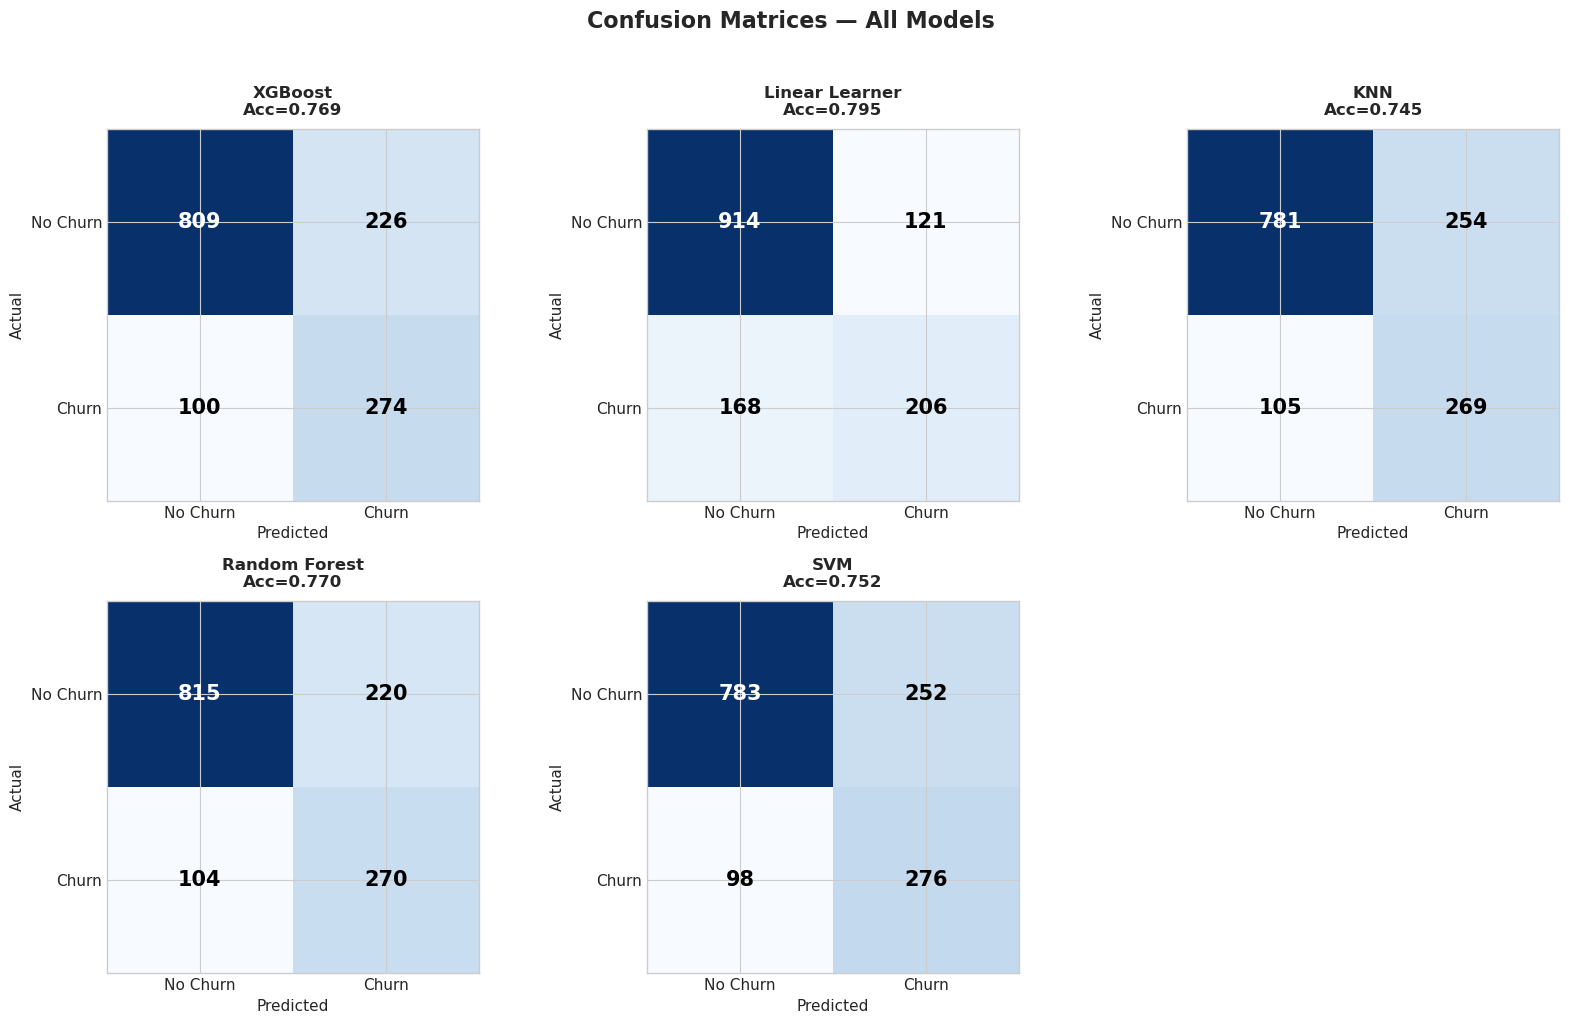

In [20]:
# ============================================================
# CONFUSION MATRICES — ALL MODELS
# ============================================================

n_models = len(predictions)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5.5 * n_cols, 5 * n_rows))
axes = np.array(axes).flatten() if n_models > 1 else [axes]

for idx, (name, metrics) in enumerate(eval_metrics.items()):
    ax = axes[idx]
    cm = metrics['confusion_matrix']
    
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f'{cm[i, j]:,}',
                    ha='center', va='center', fontsize=15, fontweight='bold',
                    color='white' if cm[i, j] > thresh else 'black')
    
    acc = eval_metrics[name]['Accuracy']
    ax.set_title(f'{name}\nAcc={acc:.3f}', fontsize=12, fontweight='bold', pad=10)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['No Churn', 'Churn'])
    ax.set_yticklabels(['No Churn', 'Churn'])

# Hide unused subplots
for idx in range(n_models, len(axes)):
    axes[idx].set_visible(False)

fig.suptitle('Confusion Matrices — All Models', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

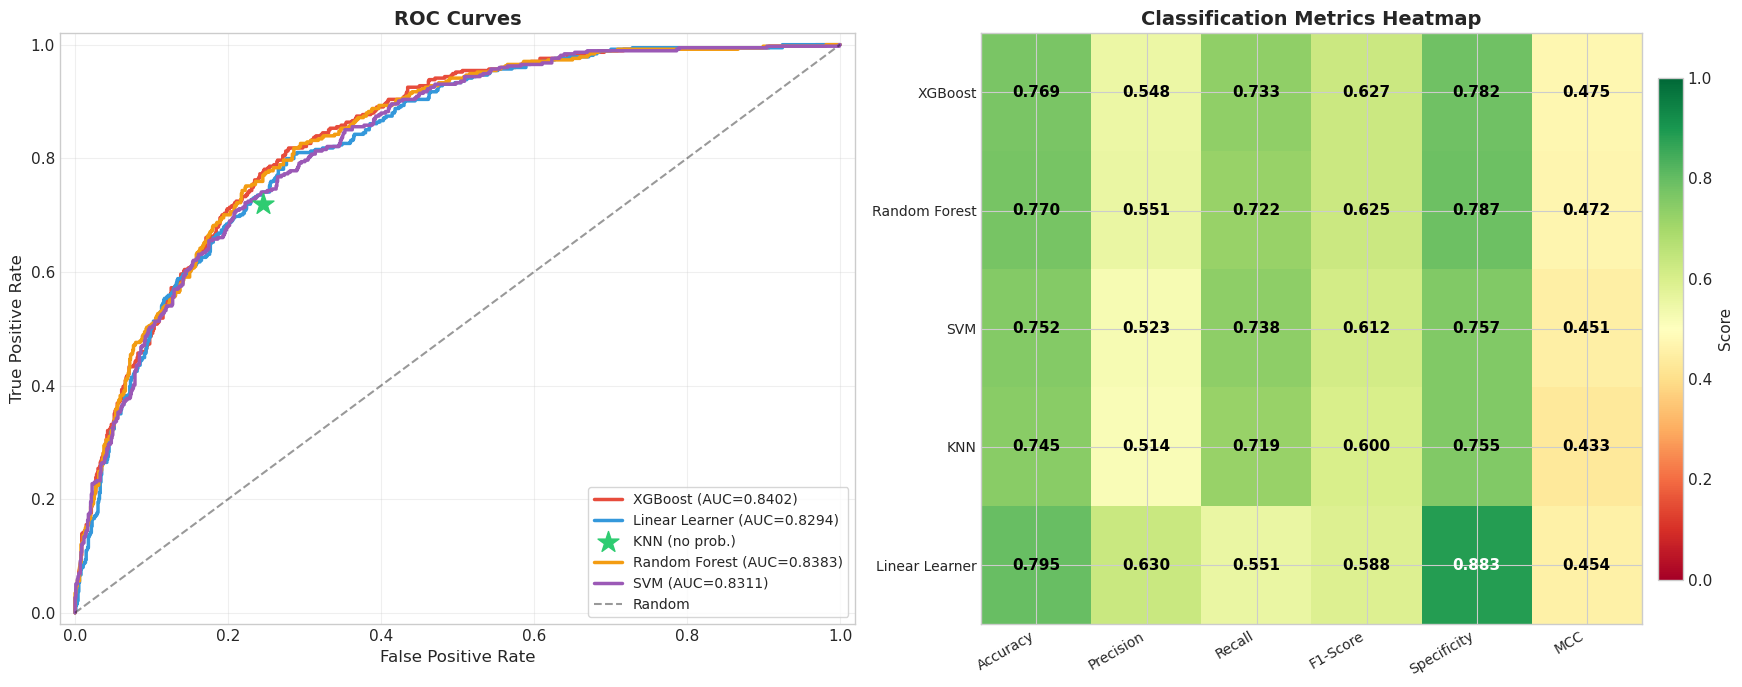

In [21]:
# ============================================================
# ROC CURVES + METRICS HEATMAP
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- Left: ROC Curves ---
ax_roc = axes[0]
palette = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']

for idx, (name, pred_data) in enumerate(predictions.items()):
    color = palette[idx % len(palette)]
    if pred_data['y_prob'] is not None:
        fpr, tpr, _ = roc_curve(y_test, pred_data['y_prob'])
        auc_val = roc_auc_score(y_test, pred_data['y_prob'])
        ax_roc.plot(fpr, tpr, color=color, lw=2.5,
                    label=f'{name} (AUC={auc_val:.4f})')
    else:
        # Models without probability output — plot as a single operating point
        m = eval_metrics[name]
        fpr_pt = 1 - m['Specificity']
        ax_roc.scatter(fpr_pt, m['Recall'], marker='*', s=250, color=color,
                       zorder=5, label=f'{name} (no prob.)')

ax_roc.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.4, label='Random')
ax_roc.set_xlabel('False Positive Rate', fontsize=12)
ax_roc.set_ylabel('True Positive Rate', fontsize=12)
ax_roc.set_title('ROC Curves', fontsize=14, fontweight='bold')
ax_roc.legend(loc='lower right', fontsize=10, frameon=True)
ax_roc.set_xlim([-0.02, 1.02])
ax_roc.set_ylim([-0.02, 1.02])
ax_roc.grid(alpha=0.3)

# --- Right: Metrics Heatmap ---
ax_hm = axes[1]
hm_cols = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificity', 'MCC']
hm_cols = [c for c in hm_cols if c in metrics_df.columns]
hm_data = metrics_df.set_index('Model')[hm_cols]

im = ax_hm.imshow(hm_data.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
for i in range(len(hm_data)):
    for j in range(len(hm_cols)):
        val = hm_data.values[i, j]
        color = 'white' if val < 0.3 or val > 0.85 else 'black'
        ax_hm.text(j, i, f'{val:.3f}', ha='center', va='center',
                   fontsize=11, fontweight='bold', color=color)

ax_hm.set_xticks(range(len(hm_cols)))
ax_hm.set_xticklabels(hm_cols, fontsize=10, rotation=30, ha='right')
ax_hm.set_yticks(range(len(hm_data)))
ax_hm.set_yticklabels(hm_data.index, fontsize=10)
ax_hm.set_title('Classification Metrics Heatmap', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax_hm, label='Score', pad=0.02, shrink=0.85)

plt.tight_layout()
plt.show()

Extracting training metrics from SageMaker training jobs...

  XGBoost: Train=0.8957, Val=0.8402, Gap=0.0554 [Mild Overfit]
  Linear Learner: Partial metrics only (['ObjectiveMetric', 'validation:objective_loss', 'train:progress', 'validation:binary_classification_accuracy', 'validation:recall', 'train:throughput', 'validation:roc_auc_score', 'train:objective_loss', 'validation:objective_loss:final', 'validation:binary_f_beta', 'validation:precision'])
  KNN: Partial metrics only (['test:binary_f_beta', 'ObjectiveMetric', 'test:roc_auc_score', 'train:progress', 'train:throughput', 'test:accuracy'])
  Random Forest: Train=0.9142, Val=0.8383, Gap=0.0759 [Mild Overfit]
  SVM: Train=0.8769, Val=0.8311, Gap=0.0458 [Mild Overfit]


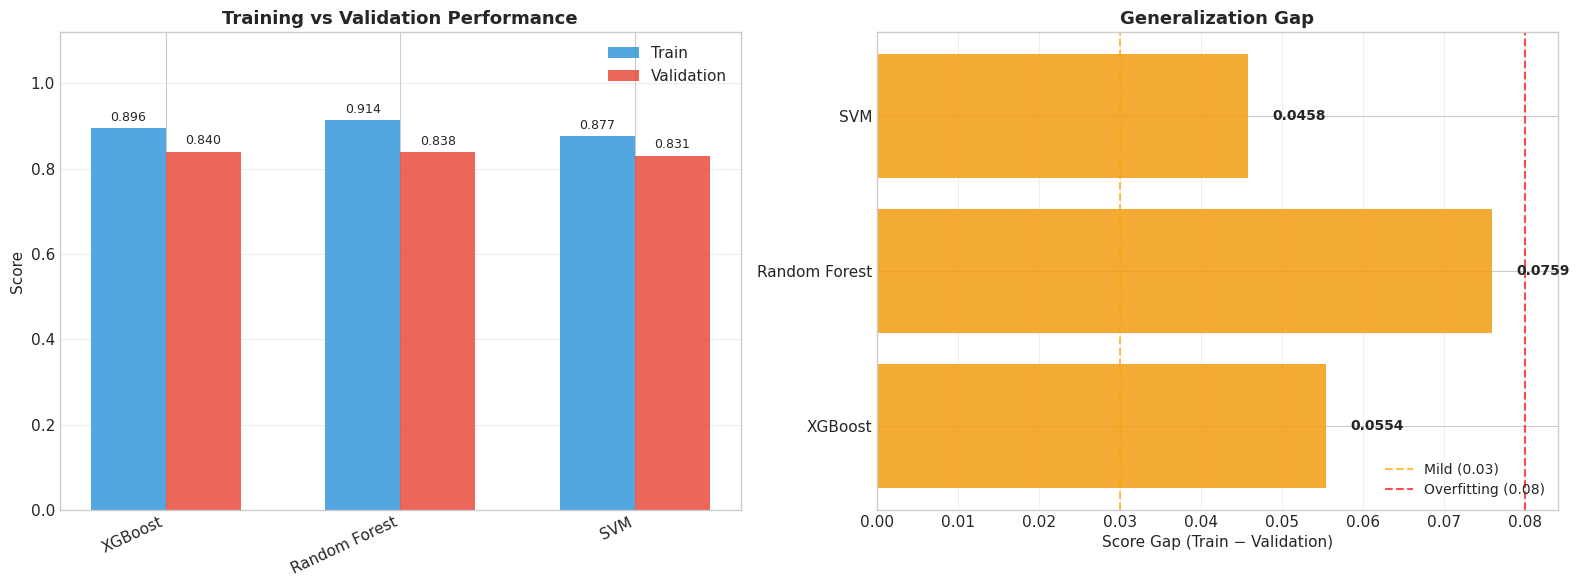


OVERFITTING SUMMARY
        Model  Train Score  Val Score    Gap       Status
      XGBoost       0.8957     0.8402 0.0554 Mild Overfit
Random Forest       0.9142     0.8383 0.0759 Mild Overfit
          SVM       0.8769     0.8311 0.0458 Mild Overfit


In [22]:
# ============================================================
# OVERFITTING ANALYSIS: Training vs Validation Performance
# ============================================================
print("Extracting training metrics from SageMaker training jobs...\n")

sm_client = boto3.client('sagemaker')

# Metric name mappings per algorithm (train_metric, val_metric)
TRAIN_METRIC_MAP = {
    'XGBoost':        ('train:auc',            'validation:auc'),
    'Linear Learner': ('train:binary_f_beta',  'validation:binary_f_beta'),
    'KNN':            ('train:accuracy',       'test:accuracy'),
    'Random Forest':  ('Train-AUC',            'Test-AUC'),
    'SVM':            ('Train-AUC',            'Test-AUC'),
}

overfit_records = []
for name, data in model_results.items():
    job_name = data['Job']
    try:
        desc = sm_client.describe_training_job(TrainingJobName=job_name)
        final_metrics = {m['MetricName']: m['Value']
                         for m in desc.get('FinalMetricDataList', [])}
        
        train_key, val_key = TRAIN_METRIC_MAP.get(name, (None, None))
        train_score = final_metrics.get(train_key)
        val_score = final_metrics.get(val_key)
        
        if train_score is not None and val_score is not None:
            gap = train_score - val_score
            if gap < 0.03:
                status = 'Good'
            elif gap < 0.08:
                status = 'Mild Overfit'
            else:
                status = 'Overfitting'
            overfit_records.append({
                'Model': name,
                'Train Score': train_score,
                'Val Score': val_score,
                'Gap': gap,
                'Status': status
            })
            print(f"  {name}: Train={train_score:.4f}, Val={val_score:.4f}, Gap={gap:.4f} [{status}]")
        else:
            print(f"  {name}: Partial metrics only ({list(final_metrics.keys())})")
    except Exception as e:
        print(f"  {name}: Could not retrieve — {e}")

# --- Visualization ---
if overfit_records:
    overfit_df = pd.DataFrame(overfit_records)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left: Grouped bar — train vs validation
    ax1 = axes[0]
    x = np.arange(len(overfit_df))
    w = 0.32
    bars_train = ax1.bar(x - w/2, overfit_df['Train Score'], w,
                         label='Train', color='#3498db', alpha=0.85)
    bars_val   = ax1.bar(x + w/2, overfit_df['Val Score'], w,
                         label='Validation', color='#e74c3c', alpha=0.85)
    
    for bars in [bars_train, bars_val]:
        for bar in bars:
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                     f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=9)
    
    ax1.set_xticks(x)
    ax1.set_xticklabels(overfit_df['Model'], rotation=25, ha='right')
    ax1.set_ylabel('Score')
    ax1.set_title('Training vs Validation Performance', fontsize=13, fontweight='bold')
    ax1.set_ylim(0, 1.12)
    ax1.legend(fontsize=11)
    ax1.grid(axis='y', alpha=0.3)
    
    # Right: Horizontal bar — generalization gap
    ax2 = axes[1]
    gap_colors = ['#2ecc71' if g < 0.03 else '#f39c12' if g < 0.08 else '#e74c3c'
                  for g in overfit_df['Gap']]
    bars = ax2.barh(overfit_df['Model'], overfit_df['Gap'], color=gap_colors, alpha=0.85)
    ax2.axvline(x=0.03, color='orange', ls='--', alpha=0.7, label='Mild (0.03)')
    ax2.axvline(x=0.08, color='red',    ls='--', alpha=0.7, label='Overfitting (0.08)')
    
    for bar, gap in zip(bars, overfit_df['Gap']):
        ax2.text(bar.get_width() + 0.003, bar.get_y() + bar.get_height()/2,
                 f'{gap:.4f}', va='center', fontsize=10, fontweight='bold')
    
    ax2.set_xlabel('Score Gap (Train − Validation)')
    ax2.set_title('Generalization Gap', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10, loc='lower right')
    ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 80)
    print("OVERFITTING SUMMARY")
    print("=" * 80)
    print(overfit_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))
    print("=" * 80)
else:
    print("\nNo training metrics available. Run the training cells first.")

In [23]:
# ============================================================
# FINAL MODEL SELECTION
# ============================================================

# Rank by F1-Score (balances precision and recall for churn)
ranking = metrics_df.sort_values('F1-Score', ascending=False).reset_index(drop=True)
ranking.insert(0, 'Rank', range(1, len(ranking) + 1))

print("=" * 90)
print("FINAL MODEL RANKING (by F1-Score)")
print("=" * 90)
display_cols = ['Rank', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'MCC']
available = [c for c in display_cols if c in ranking.columns]
print(ranking[available].to_string(index=False, float_format=lambda x: f'{x:.4f}'))
print("=" * 90)

# Select best model
best_model_name = ranking.iloc[0]['Model']
best_model_score = ranking.iloc[0]['F1-Score']

print(f"\nBEST MODEL: {best_model_name}")
print(f"  F1-Score:    {ranking.iloc[0]['F1-Score']:.4f}")
auc_val = ranking.iloc[0].get('AUC-ROC')
if pd.notna(auc_val):
    print(f"  AUC-ROC:     {auc_val:.4f}")
print(f"  Precision:   {ranking.iloc[0]['Precision']:.4f}")
print(f"  Recall:      {ranking.iloc[0]['Recall']:.4f}")
print(f"  Accuracy:    {ranking.iloc[0]['Accuracy']:.4f}")

# For churn prediction, recall is especially important
best_recall_model = ranking.sort_values('Recall', ascending=False).iloc[0]['Model']
if best_recall_model != best_model_name:
    best_recall_val = ranking.sort_values('Recall', ascending=False).iloc[0]['Recall']
    print(f"\nNote: {best_recall_model} has the highest Recall ({best_recall_val:.4f}).")
    print("  Consider it if maximizing churn detection (minimizing missed churners) is the priority.")

print(f"\n{'=' * 90}")

FINAL MODEL RANKING (by F1-Score)
 Rank          Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC    MCC
    1        XGBoost    0.7686     0.5480  0.7326    0.6270   0.8402 0.4746
    2  Random Forest    0.7700     0.5510  0.7219    0.6250   0.8383 0.4723
    3            SVM    0.7516     0.5227  0.7380    0.6120   0.8311 0.4511
    4            KNN    0.7452     0.5143  0.7193    0.5998      NaN 0.4331
    5 Linear Learner    0.7949     0.6300  0.5508    0.5877   0.8294 0.4538

BEST MODEL: XGBoost
  F1-Score:    0.6270
  AUC-ROC:     0.8402
  Precision:   0.5480
  Recall:      0.7326
  Accuracy:    0.7686

Note: SVM has the highest Recall (0.7380).
  Consider it if maximizing churn detection (minimizing missed churners) is the priority.

